In [20]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
wd = 'release'
figsize = (6, 4)

In [27]:
# Analysis of test_levels
def read_tests(fn, verbose=False):
    df = []
    with open(fn, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            if 'Running with' in line:
                data = {'level':[], 'time(s)':[], 'numTasks':[], 'proc':[],'cost_local':[], 'cost_global':[]}
                level = int(line.split('=')[-1].strip())
            elif 'Generated ' in line:
                numTasks = int(line.split(' ')[1])
            elif 'Proc ' in line:
                tokens = line.split(' ')
                proc = int(tokens[1])
                time = float(tokens[4])
                cost_local = tokens[-2].split('=')[-1].replace(',', '')
                cost_global = tokens[-1].split('=')[-1].replace(')', '')
                # add data row
                data['level'].append(level)            
                data['time(s)'].append(time)
                data['numTasks'].append(numTasks)
                data['proc'].append(proc)
                data['cost_local'].append(float(cost_local))
                data['cost_global'].append(float(cost_global))
            elif 'Maximum resident set size (kbytes):' in line:
                # convert to DataFrame
                data = pd.DataFrame(data)
                data['peakMem(KB)'] = int(line.split(' ')[-1])
                if(verbose):
                    display(data)
                df.append(data)
    # merge all dataframes
    df = pd.concat(df)
    df['peakMem(GB)'] = df['peakMem(KB)'] / 1024 / 1024
    # drop peakMem(KB)
    df.drop(columns=['peakMem(KB)'], inplace=True)
    return df

In [28]:
df_levels = read_tests(os.path.join(wd,'tests_level.txt'))
display(df_levels.columns)

Index(['level', 'time(s)', 'numTasks', 'proc', 'cost_local', 'cost_global',
       'peakMem(GB)'],
      dtype='object')

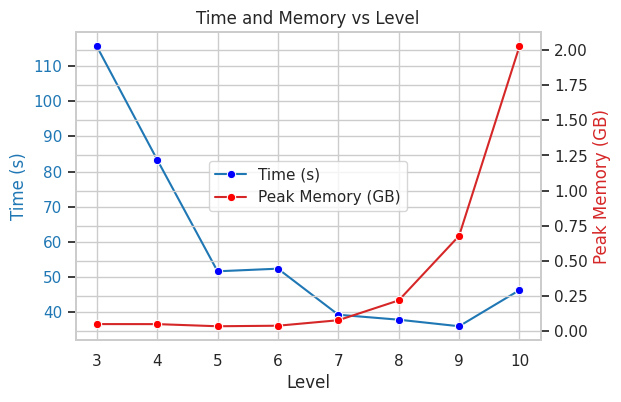

In [23]:
# Fig. Tuning level based on time and memory
# Group by level and get the maximum time and peak memory
df_agg = df_levels.groupby('level').agg({'time(s)': 'max', 'peakMem(GB)': 'max'}).reset_index()

# Create the plot with a shared x-axis
fig, ax1 = plt.subplots(figsize=figsize)

# Create the first plot (time vs level)
sns.lineplot(data=df_agg, x='level', y='time(s)', marker='o', ax=ax1, label='Time (s)', color='tab:blue', markerfacecolor='blue')
ax1.set_ylabel('Time (s)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second y-axis
ax2 = ax1.twinx()

# Create the second plot (peak memory vs level)
sns.lineplot(data=df_agg, x='level', y='peakMem(GB)', marker='o', ax=ax2, color='tab:red', label='Peak Memory (GB)', markerfacecolor='red')
ax2.set_ylabel('Peak Memory (GB)', color='tab:red')

# Set the title and x-axis label
plt.title('Time and Memory vs Level')
ax1.set_xlabel('Level')

# Get handles and labels from both axes for the combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Add a single combined legend
ax2.legend(lines + lines2, labels + labels2, loc='center')

# Remove the first legend (from ax1)
ax1.get_legend().remove()

# Show the plot
plt.show()

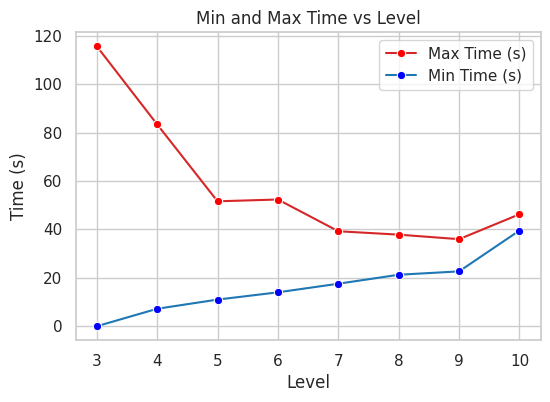

In [12]:
# Table: Min and Max time for each level (unbalancing measure)
df_agg = {'level':[], 'minTime(s)':[], 'maxTime(s)':[]}
for level in set(df_levels['level']):
    df = df_levels[df_levels['level'] == level]
    df_agg['level'].append(level)
    df_agg['minTime(s)'].append(df['time(s)'].min())
    df_agg['maxTime(s)'].append(df['time(s)'].max())
df_agg = pd.DataFrame(df_agg)
df_agg

# Create a plot to illustrate the unbalancing measure
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(data=df_agg, x='level', y='maxTime(s)', marker='o', label='Max Time (s)', color='tab:red', markerfacecolor='red')
sns.lineplot(data=df_agg, x='level', y='minTime(s)', marker='o', label='Min Time (s)', color='tab:blue', markerfacecolor='blue')
plt.title('Min and Max Time vs Level')
plt.xlabel('Level')
plt.ylabel('Time (s)')
plt.legend()
plt.show()


In [45]:
df_scaling = read_tests(os.path.join(wd,'tests_scaling.txt'))
df_scaling.rename(columns={'level':'np'}, inplace=True)

,np,time(s),peakMem(GB)
0,1,271.992,9.608837
1,2,141.573,4.845364
2,3,104.613,3.271900
3,4,77.217,2.466282
4,5,62.120,1.989616
5,6,56.798,1.678028
6,7,51.927,1.457615
7,8,46.705,1.275997
8,9,43.990,1.146603
9,10,42.074,1.035179


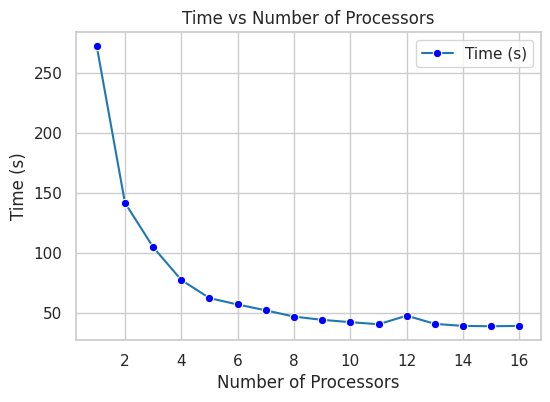

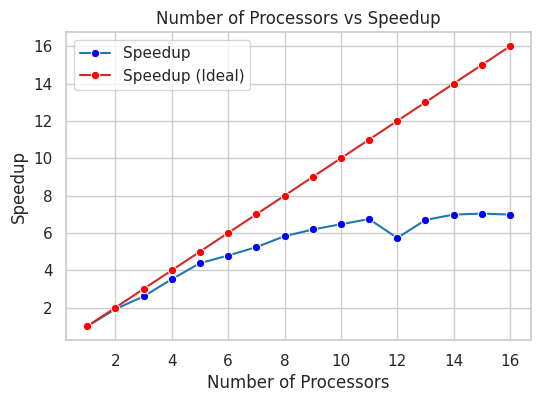

In [46]:
df_agg = df_scaling.groupby('np').agg({'time(s)': 'max', 'peakMem(GB)': 'max'}).reset_index()
display(df_agg)

# Paralellism vs Time
fig = plt.figure(figsize=figsize)
sns.lineplot(data=df_agg, x='np', y='time(s)', marker='o', label='Time (s)', color='tab:blue', markerfacecolor='blue')
plt.title('Time vs Number of Processors')
plt.xlabel('Number of Processors')
plt.ylabel('Time (s)')
plt.show()

# Parallelism vs Speedup
timeNP1 = df_agg[df_agg['np'] == 1]['time(s)'].values[0]
df_agg['speedup'] = timeNP1 / df_agg['time(s)']
df_agg['speedup (ideal)'] = df_agg['np']
fig = plt.figure(figsize=figsize)
sns.lineplot(data=df_agg, x='np', y='speedup', marker='o', label='Speedup', color='tab:blue', markerfacecolor='blue')
sns.lineplot(data=df_agg, x='np', y='speedup (ideal)', marker='o', label='Speedup (Ideal)', color='tab:red', markerfacecolor='red')
plt.title('Number of Processors vs Speedup')
plt.xlabel('Number of Processors')
plt.ylabel('Speedup')
plt.show()

In [47]:
def read_stats(fn: str) -> pd.DataFrame:
    with open (fn, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    # drop line 0 it is artifact
    df = df.drop(0)
    return df

def read_best(fn: str) -> pd.DataFrame:
    with open (fn, 'r') as f:
        data = json.load(f)
    data['best_x'] = np.array(data['best_x']).reshape(-1, 3).tolist()    
    df = pd.DataFrame(data, columns=['best_y', 'best_x', 'best_cost'])
    df.rename(columns={'best_y': 'y', 'best_x': 'x', 'best_cost': 'cost'}, inplace=True)
    # drop line 0 it is artifact
    df = df.drop(0)
    return df

In [61]:
def read_results():    
    prefixes = set([fn.replace('_best.json','').replace('_stats.json','') for fn in os.listdir(wd) if 'run_h_24_' in fn])
    df = []
    for prefix in sorted(prefixes):
        if '_prof.txt' in prefix:
            continue
        try:
            df_best = read_best(os.path.join(wd, prefix + '_best.json'))
            df_stats = read_stats(os.path.join(wd, prefix + '_stats.json'))
        except:
            print(f'Error reading {prefix}, skipping...')
            continue
        # merge best and stats
        df_local = pd.concat([df_best, df_stats], axis=1)
        # add rank
        rank = int(prefix.split('_r_')[1].split('_')[0])
        df_local['rank'] = rank
        # add actuations
        actuations = int(prefix.split('_a_')[1].split('_')[0])
        df_local['actuations'] = actuations
        # add prefix
        df_local['prefix'] = prefix        
        df.append(df_local)        
    # return merged dataframes
    return pd.concat(df)

df = read_results() 
# df


Error reading run_h_24_a_02_l_03_n_16_r_03, skipping...
Error reading run_h_24_a_02_l_03_n_16_r_04, skipping...
Error reading run_h_24_a_03_l_09_n_16_r_03, skipping...


,y,x,cost,ACTUATIONS,COST,LEVELS,NONE,PRESSURES,STABILITY,TIMESTEP,duration,rank,actuations,prefix
1,1,"[1, 0, 0]",3914.398067,0,0,0,0,0,0,1,1.760160,0,1,run_h_24_a_01_l_00_n_01_r_00
2,1,"[1, 0, 0]",3914.398067,0,0,0,13,0,0,2,1.760160,0,1,run_h_24_a_01_l_00_n_01_r_00
3,1,"[1, 0, 0]",3914.398067,0,0,0,27,0,0,13,1.760160,0,1,run_h_24_a_01_l_00_n_01_r_00
4,1,"[1, 0, 0]",3914.398067,15,0,0,63,0,0,30,1.760160,0,1,run_h_24_a_01_l_00_n_01_r_00
5,1,"[1, 0, 0]",3914.398067,56,0,0,123,0,0,73,1.760160,0,1,run_h_24_a_01_l_00_n_01_r_00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,0,"[0, 0, 0]",3624.651074,584851,1188557,0,489747,1318,0,601596,435.236555,15,3,run_h_24_a_03_l_09_n_16_r_15
21,0,"[0, 0, 0]",3624.651074,163858,455428,0,12004,229,0,473190,435.236555,15,3,run_h_24_a_03_l_09_n_16_r_15
22,1,"[1, 0, 0]",3624.651074,6572,8472,0,2030,6,0,18402,435.236555,15,3,run_h_24_a_03_l_09_n_16_r_15
23,1,"[1, 0, 0]",3624.651074,1686,1931,0,502,0,0,584,435.236555,15,3,run_h_24_a_03_l_09_n_16_r_15


In [98]:
def show_prunes(df_local: pd.DataFrame):
    columns = [c for c in df_local.columns if c not in ['y','x','cost','duration','actuations','prefix','rank']]
    df_prunes = df_local[columns].copy().reset_index()
    df_prunes['h'] = np.arange(len(df_prunes)) % 24 + 1
    df_agg = df_prunes.groupby('h').agg('sum').reset_index()
    df_agg.drop(columns=['index'], inplace=True)
    df_agg.rename({'NONE':'FEASIBLE'}, inplace=True)
    total = np.zeros(len(df_agg))
    for c in df_agg.columns:
        if c != 'h':
            total += df_agg[c]
    df_agg['TOTAL'] = total
    df_agg['TOTAL'] = df_agg['TOTAL'].astype(int)
    # organize columns
    columns = ['h','FEASIBLE'] + [c for c in df_agg.columns if c not in ['h','FEASIBLE','TOTAL']] + ['TOTAL']
    print('Prunes:')
    display(df_agg)

def show_best(prefix:str):
    df_local = df[df['prefix'].str.contains(prefix)]
    if len(df_local) == 0:
        print(f'No data for prefix: {prefix}')
        return
    best_cost = df_local['cost'].min()
    df_best = df_local[df_local['cost'] == best_cost]
    prefix = df_best['prefix'].values[0]
    duration = df_local['duration'].max()
    a = int(prefix.split('_a_')[1].split('_')[0])
    n = int(prefix.split('_n_')[1].split('_')[0])
    y = df_best['y'].tolist()
    y_str = ''.join([f'{v}' for v in y])    
    x = np.array(df_best['x'].tolist())
    x1_str = 'best x: ' + ''.join([f'{v}' for v in x[:,0]])
    x2_str = '        ' + ''.join([f'{v}' for v in x[:,1]])
    x3_str = '        ' + ''.join([f'{v}' for v in x[:,2]])
    print(f'max actuations: {a}, nprocs: {n}')
    print(f'best cost: ${best_cost:.2f}')
    print(f'duration : {duration:.2f} s')
    print(f'best y: {y_str}')    
    print(x1_str)
    print(x2_str)
    print(x3_str)
    print(f'prefix: {prefix}\n')    
    show_prunes(df_local)    

show_best('run_h_24_a_01_l_01_n_01')
show_best('run_h_24_a_02_l_09_n_16')
show_best('run_h_24_a_03_l_09_n_16')

max actuations: 1, nprocs: 1
best cost: $3914.40
duration : 1.69 s
best y: 111111111112112222000111
best x: 111111111111000000000111
        000000000001111111000000
        000000000000001111000000
prefix: run_h_24_a_01_l_01_n_01_r_00

Prunes:


,h,ACTUATIONS,COST,LEVELS,NONE,PRESSURES,STABILITY,TIMESTEP,TOTAL
0,1,0,0,0,3,0,0,1,4
1,2,0,0,0,10,0,0,2,12
2,3,0,0,0,27,0,0,13,40
3,4,15,0,0,63,0,0,30,108
4,5,56,0,0,123,0,0,73,252
5,6,150,0,0,218,0,0,124,492
6,7,313,0,0,412,1,0,146,872
7,8,716,0,0,688,0,0,244,1648
8,9,1340,0,0,1018,1,0,393,2752
9,10,2146,0,0,1490,2,0,434,4072


max actuations: 2, nprocs: 16
best cost: $3586.26
duration : 38.95 s
best y: 212111111122221111000210
best x: 100000000011111111000000
        111000000000000000000100
        001111111111110000000110
prefix: run_h_24_a_02_l_09_n_16_r_03

Prunes:


,h,ACTUATIONS,COST,LEVELS,NONE,PRESSURES,STABILITY,TIMESTEP,TOTAL
0,1,0,0,0,146795,0,0,44087,190882
1,2,0,0,0,120862,0,0,25933,146795
2,3,0,0,0,77957,0,0,42905,120862
3,4,0,0,0,54756,0,0,23201,77957
4,5,0,0,0,35880,0,0,18876,54756
5,6,0,0,0,23719,0,0,12161,35880
6,7,0,0,0,17521,16,0,6182,23719
7,8,0,0,0,12943,4,0,4574,17521
8,9,0,0,0,9640,21,0,3282,12943
9,10,8038,0,0,22147,166,0,8209,38560


max actuations: 3, nprocs: 16
best cost: $3533.73
duration : 517.23 s
best y: 122111101311112330001210
best x: 111000000100000110000000
        011111100111111110001100
        000000001100001110000110
prefix: run_h_24_a_03_l_09_n_16_r_07

Prunes:


,h,ACTUATIONS,COST,LEVELS,NONE,PRESSURES,STABILITY,TIMESTEP,TOTAL
0,1,0,0,0,183162,0,0,60652,243814
1,2,0,0,0,152513,0,0,30649,183162
2,3,0,0,0,102669,0,0,49844,152513
3,4,0,0,0,71149,0,0,31520,102669
4,5,0,0,0,46724,0,0,24425,71149
5,6,0,0,0,30409,0,0,16315,46724
6,7,0,0,0,22373,15,0,8021,30409
7,8,0,0,0,16852,4,0,5517,22373
8,9,0,0,0,12781,27,0,4044,16852
9,10,1157,0,0,37179,402,0,12386,51124
